# Train and evaluate models

This notebooks shows how to train, predict and cluster models. Alternatively to executing each step here, the CLI can be used for training models:
```
campa train all --config $CAMPA_DIR/notebooks/params/example_experiment_params.py
```

For evaluation or comparison only, use
```
campa train compare --experiment-dir test
```

Before running this tutorial, make sure you create the [NNDataset][] with the [create NNDataset tutorial](nn_dataset.ipynb).
The models trained here will be saved in `EXPERIMENT_DIR/test`, with the `EXPERIMENT_DIR` being the custom experiment path set up in [campa_config][].

[NNDataset]: ../classes/campa.data.NNDataset.rst
[campa_config]: ../api/campa.constants.campa_config.rst



In [1]:
from campa.tl import (
    Cluster,
    Estimator,
    Predictor,
    Experiment,
    ModelComparator,
    run_experiments,
)
from campa.data import MPPData
from campa.constants import campa_config
from campa.utils import init_logging
import os

# init logging with level INFO=20, WARNING=30
init_logging(level=30)
# read correct campa_config -- created with setup.ipynb
campa_config.config_fname = 'params/campa.ini'
print(campa_config)

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


/Users/hannah.spitzer/opt/miniconda3/envs/campa/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'plotting' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


Reading config from params/campa.ini
CAMPAConfig (fname: params/campa.ini)
EXPERIMENT_DIR: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments
BASE_DATA_DIR: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/raw
CO_OCC_CHUNK_SIZE: 10000000.0
data_config/nascentrna: /Users/hannah.spitzer/projects/pelkmans/software_new/campa_ana/NascentRNA_constants.py
data_config/testdata: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/tests/_data/TestData_constants.py
data_config/exampledata: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/params/ExampleData_constants.py



## Experiment class handles config files
For training and evaluating models, an `experiment_params.py` file is used. This file contains several model/experiment parameters for easy training of several models at the same time. The parameter dictionaries contain several sections:

- experiment (where to save experiment)
- data (which dataset to use for training)
- model (model class definition)
- training (training hyperparameters)
- evaluation (evaluation on val/test split)
- cluster (clustering on val/test split)

For more information on the structure of the experiment parameter dictionary, see the documentation of [Experiment][]
The [Experiment][] class is initialised from a parameter dictionary for one specific experiment and is passed to specific classes for training ([Estimator][]), evaluation ([Predictor][]), and clustering ([Cluster][]).

Here, we are going to be using an [example experiment config](https://github.com/theislab/campa/blob/main/notebooks/params/example_experiment_params.py) that creates three models:
- `condVAE`: a cVAE model trained on the example dataset created in [the NNDataset tutorial](nn_dataset.ipynb), using perturbation (unperturbed or Meayamycin) and cell cycle as conditions
- `VAE`: a VAE model trained on the example dataset created in [the NNDataset tutorial](nn_dataset.ipynb), 
- `MPPleiden`: a non-traineable model that is used to create a direct pixel clustering, to compare with the cVAE latent space clustering.

First, we create the Experiments from the example config file:

[Experiment]: ../classes/campa.tl.Experiment.rst
[Estimator]: ../classes/campa.tl.Estimator.rst
[Predictor]: ../classes/campa.tl.Predictor.rst
[Cluster]: ../classes/campa.tl.Cluster.rst



In [2]:
# get Experiments from config
exps = Experiment.get_experiments_from_config("params/example_experiment_params.py")

Experiments are saved in `EXPERIMENT_DIR/<experiment_dir>/<experiment_name>`, where `EXPERIMENT_DIR` is the directory set up in `campa_config`, and `<experiment_dir>` and `<experiment_name>` are defined in the experiment config. The experiment config can be accessed with [Experiment.config][] and is stored as `config.json` in the experiment folder.

[Experiment.config]: ../classes/campa.tl.Experiment.config.rst

In [3]:
exp = exps[0]
print("Experiment name:", exp.name)
print("Experiment is stored in:", exp.full_path)
print("Experiment config:", exp.config)

Experiment name: VAE
Experiment is stored in: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/VAE
Experiment config: {'experiment': {'dir': 'test', 'name': 'VAE', 'save_config': True}, 'data': {'data_config': 'ExampleData', 'dataset_name': '184A1_test_dataset', 'output_channels': None}, 'model': {'model_cls': <ModelEnum.VAEModel: 'VAEModel'>, 'model_kwargs': {'num_neighbors': 3, 'num_channels': 34, 'num_output_channels': 34, 'latent_dim': 16, 'encoder_conv_layers': [32], 'encoder_conv_kernel_size': [1], 'encoder_fc_layers': [32, 16], 'decoder_fc_layers': []}, 'init_with_weights': False}, 'training': {'learning_rate': 0.001, 'epochs': 10, 'batch_size': 128, 'loss': {'decoder': <LossEnum.SIGMA_MSE: 'sigma_vae_mse'>, 'latent': <LossEnum.KL: 'kl_divergence'>}, 'loss_weights': {'decoder': 1}, 'loss_warmup_to_epoch': {}, 'metrics': {'decoder': <LossEnum.MSE_metric: 'mean_squared_error_metric'>, 'latent': <LossEnum.KL: 'kl_divergence'>}, 'save_mod

## Running experiments with the high-level api

The high-level api contains a [run_experiments()][run_experiments] function that wraps training, evaluation, clustering and comparison of models in one call. 

[run_experiments]: ../api/campa.tl.run_experiments.rst

In [4]:
run_experiments(exps, mode="trainval")

Running experiment for ['VAE', 'CondVAE_pert-CC', 'MPPleiden'] with mode trainval
Training model for VAE


2022-04-22 15:08:41.800555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


This should have created the three trained experiments in ``EXPERIMENT_DIR/test`` (test is the `<experiment_dir>` defined in the config):

In [ ]:
os.listdir(os.path.join(campa_config.EXPERIMENT_DIR, 'test'))

['CondVAE_pert-CC', 'MPPleiden', 'VAE']

## Running experiments with Estimator and Predictor
Now, we will be using the cVAE experiment to show how to use the Estimator and Predictor classes.
Note that if you ran the command above, this model is already trained, and the below commands will re-train it.

### Neural network training with Estimator
The [Estimator][] class handles model setup, training, and prediction. It is instanciated from an [Experiment][].


[Experiment]: ../classes/campa.tl.Experiment.rst
[Estimator]: ../classes/campa.tl.Estimator.rst
[Predictor]: ../classes/campa.tl.Predictor.rst
[Cluster]: ../classes/campa.tl.Cluster.rst

In [ ]:
exp = exps[1]
print("Experiment name:", exp.name)
print("Experiment is stored in:", exp.full_path)

Experiment name: CondVAE_pert-CC
Experiment is stored in: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/CondVAE_pert-CC


In [ ]:
est = Estimator(exp)

The [Estimator.train_model()][Estimator.train_model] function is used to train the experiment.

[Estimator.train_model]: ../classes/campa.tl.Estimator.train_model.rst

In [ ]:
est.train_model()

Epoch 1/10
394/394 [==============================] - 12s 22ms/step - loss: -3199.6880 - decoder_loss: -3207.1980 - latent_loss: 7.5110 - decoder_mean_squared_error: 0.0134 - latent_kl_loss: 7.5115 - val_loss: -2782.5261 - val_decoder_loss: -2790.3501 - val_latent_loss: 7.8252 - val_decoder_mean_squared_error: 0.0165 - val_latent_kl_loss: 7.8258
Epoch 2/10


394/394 [==============================] - 12s 23ms/step - loss: -3228.6628 - decoder_loss: -3236.1721 - latent_loss: 7.5093 - decoder_mean_squared_error: 0.0133 - latent_kl_loss: 7.5087 - val_loss: -2851.1318 - val_decoder_loss: -2858.9397 - val_latent_loss: 7.8075 - val_decoder_mean_squared_error: 0.0160 - val_latent_kl_loss: 7.8080
Epoch 3/10
394/394 [==============================] - 12s 24ms/step - loss: -3253.5146 - decoder_loss: -3261.0181 - latent_loss: 7.5026 - decoder_mean_squared_error: 0.0131 - latent_kl_loss: 7.5028 - val_loss: -2833.2688 - val_decoder_loss: -2840.9878 - val_latent_loss: 7.7189 - val_decoder_mean_squared_error: 0.0161 - val_latent_kl_loss: 7.7194
Epoch 4/10
394/394 [==============================] - 10s 21ms/step - loss: -3272.2427 - decoder_loss: -3279.6743 - latent_loss: 7.4314 - decoder_mean_squared_error: 0.0130 - latent_kl_loss: 7.4334 - val_loss: -2901.4656 - val_decoder_loss: -2909.1426 - val_latent_loss: 7.6776 - val_decoder_mean_squared_error: 0.0

loss  decoder_loss  latent_loss  decoder_mean_squared_error  \
epoch                                                                       
0     -3199.687988  -3207.197998     7.511045                    0.013447   
1     -3228.662842  -3236.172119     7.509336                    0.013268   
2     -3253.514648  -3261.018066     7.502631                    0.013116   
3     -3272.242676  -3279.674316     7.431427                    0.013007   
4     -3289.013672  -3296.434082     7.420682                    0.012906   
5     -3302.751953  -3310.138184     7.385983                    0.012824   
6     -3313.192871  -3320.534668     7.342348                    0.012766   
7     -3323.635742  -3330.912598     7.279145                    0.012701   
8     -3332.359619  -3339.619385     7.260695                    0.012655   
9     -3338.512451  -3345.701416     7.189095                    0.012618   

       latent_kl_loss     val_loss  val_decoder_loss  val_latent_loss  \
epoch                                                                   
0            7.511498 -2782.526123      -2790.350098         7.825234   
1            7.508748 -2851.131836      -2858.939697         7.807462   
2            7.502774 -2833.268799      -2840.987793         7.718935   
3            7.433409 -2901.465576      -2909.142578         7.677576   
4            7.417222 -2881.751709      -2889.458008         7.706760   
5            7.384471 -2928.936035      -2936.578613         7.642441   
6            7.345525 -2911.253906      -2918.844482         7.590990   
7            7.276976 -2956.808838      -2964.409668         7.600321   
8            7.258686 -2910.918945      -2918.397949         7.479305   
9            7.188084 -2969.327393      -2976.797852         7.471449   

       val_decoder_mean_squared_error  val_latent_kl_loss  
epoch                                                      
0                            0.016508            7.825809  
1                            0.015972            7.807959  
2                            0.016087            7.719394  
3                            0.015584            7.677982  
4                            0.015730            7.707124  
5                            0.015379            7.642766  
6                            0.015518            7.591213  
7                            0.015165            7.600507  
8                            0.015506            7.479447  
9                            0.015096            7.471559

This saves the weights of the best model in the experiment directory.

In [ ]:
print(os.listdir(exp.full_path))

['weights_epoch010.data-00000-of-00001', 'weights_epoch010.index', 'checkpoint', 'config.json', 'history.csv', 'results_epoch010', 'results_epoch020', 'weights_epoch020.index', 'weights_epoch020.data-00000-of-00001']



###  Predict val split and images with Predictor
The [Predictor][Predictor] class can evaluate and predict new data from trained models. It is instanciated with an [Experiment][Experiment].

[Experiment]: ../classes/campa.tl.Experiment.rst
[Estimator]: ../classes/campa.tl.Estimator.rst
[Predictor]: ../classes/campa.tl.Predictor.rst
[Cluster]: ../classes/campa.tl.Cluster.rst

In [ ]:
pred = Predictor(exp)
pred.evaluate_model()

This function evaluates the model on the `val` and `val_imgs` split, and stores the results in a results folder inside the experiment directory.

In [ ]:
results_folder = os.path.join(pred.exp.full_path, f"results_epoch{pred.est.epoch:03d}")
print('Results folder', results_folder)
print(os.listdir(results_folder))

Results folder /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/CondVAE_pert-CC/results_epoch010
['val_imgs', 'val']


The results are stored as [`MPPData`][MPPData] objects.
Note that it is important to define `data_config` when initialising the [`MPPData`][MPPData], to ensure that the data is found.

[MPPData]: ../classes/campa.data.MPPData.rst

In [ ]:
print(MPPData.from_data_dir(os.path.join(results_folder, 'val'), data_config='ExampleData'))

MPPData for ExampleData (12340 mpps with shape (3, 3, 34) from 8 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'conditions', 'latent'].


### Cluster resulting latent space with Cluster
To get a quick overview of the generated latent space and the clustering of the latent space, we can use the [Cluster][] class to cluster the evaluation split of the data. 
To generate the final clustering utilising the entire dataset, have a look at [the clustering tutorial](cluster.ipynb). 

[Cluster]: _../classes/campa.tl.Cluster.rst

In [ ]:
cl = Cluster.from_exp_split(exps[1])

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/CondVAE_pert-CC/results_epoch010/val/clustering.npy


Cluster the val split of the dataset.
You can change the resolution of the clustering by setting the `config["leiden_resolution"]` parameter.

This will create ``npy`` files containing the clusters of every data point in the validation split in the experiment results folder

In [ ]:
print(cl.config["leiden_resolution"])
cl.create_clustering()

0.2


We can again load the evaluated val split using [MPPData][], this time including the clustering.

[MPPData]: ../classes/campa.data.MPPData.rst

In [ ]:
mpp_data = MPPData.from_data_dir(os.path.join(results_folder, 'val'), data_config='ExampleData', keys=['clustering'])
print('clustering:', mpp_data.data('clustering'))

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/CondVAE_pert-CC/results_epoch010/val/clustering.npy
clustering: ['1' '0' '1' ... '1' '0' '1']


Using this clustering, we can predict the clusters of the `val_imgs` split:

In [ ]:
# predict cluster images
_ = cl.predict_cluster_imgs(exps[1])

## Plot results using ModelComparator
The [ModelComparator][ModelComparator] class is a convenience class to allow quick comparison between different models.
Below, we will compare the `condVAE`, `VAE` and `MPPleiden` experiments that we just trained.

Note that due to the stochasticity in neural network training (e.g. due to different random initialisations), your outputs could look a bit different to the outputs in the documentation. You should be able to see the same trends though.

[ModelComparator]: _../classes/campa.tl.ModelComparator.rst

In [ ]:
# get saved experiments from dir
exps = Experiment.get_experiments_from_dir("test")
comp = ModelComparator(exps)

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/CondVAE_pert-CC/results_epoch010/val/clustering.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/CondVAE_pert-CC/results_epoch010/val_imgs/clustering.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/MPPleiden/results_epoch000/val/clustering.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/MPPleiden/results_epoch000/val_imgs/clustering.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/VAE/results_epoch010/val/clustering.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/VAE/results_epoch010/val_imgs/clus

The loss and MSE summary plots show how the `VAE` and `cVAE` model perform with respect to reconstructing the input.
Both models seem to be trained well, as indicated by the asymptotic loss curves

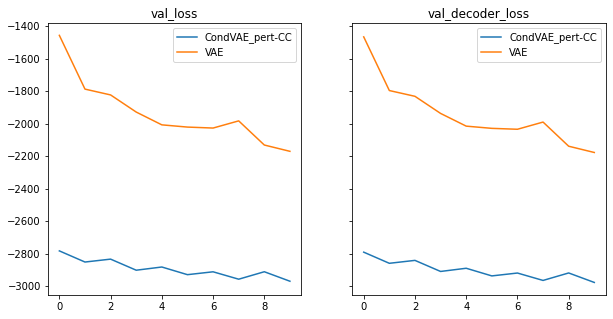

In [ ]:
comp.plot_history(values=["val_loss", "val_decoder_loss"])
comp.plot_final_score(score="val_decoder_loss", fallback_score="val_loss", save_prefix="decoder_loss_")
comp.plot_per_channel_mse()

The two example images show that both models can predict the original inputs well

In [ ]:
comp.plot_predicted_images(
    img_ids=[
        0,
        1,
    ],
    img_size=225,
)

The example leiden clustering (here with resolution 0.2 as set in the `experiment_params.py`) shows some differences between the models.
Even on these two example cells, the `MPPleiden` experiment (direct pixel clustering) seems to be less consistent across the cells. 
The `condVAE` clustering has distinct clusters for the periphery of some of the detected clusters. This is due to the training with a small local neighborhood and the very limited data size in this toy example (only 10 cells from each perturbation). To remove this effect and train without a local neighborhood, set `num_neighbors` in the model definition in the `experiment_params` and in the dataset definition in the `data_params` to 1.

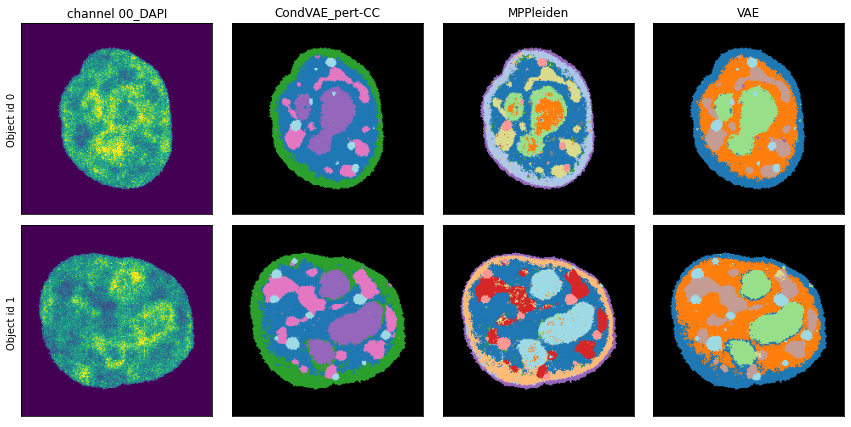

In [ ]:
comp.plot_cluster_images(
    img_ids=[
        0,
        1,
    ],
    img_size=225,
)

The pixel-level UMAP representations of the learned latent representations and the original molecular pixel profiles show that the `condVAE_pert-CC` model integrated the two perturbation best. In the two other UMAPs, several clusters are entirely only in one perturbation.

/Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/CondVAE_pert-CC/results_epoch010/val
['perturbation_duration', 'cell_cycle']
/Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/MPPleiden/results_epoch000/val
['perturbation_duration', 'cell_cycle']
/Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test/VAE/results_epoch010/val
['perturbation_duration', 'cell_cycle']


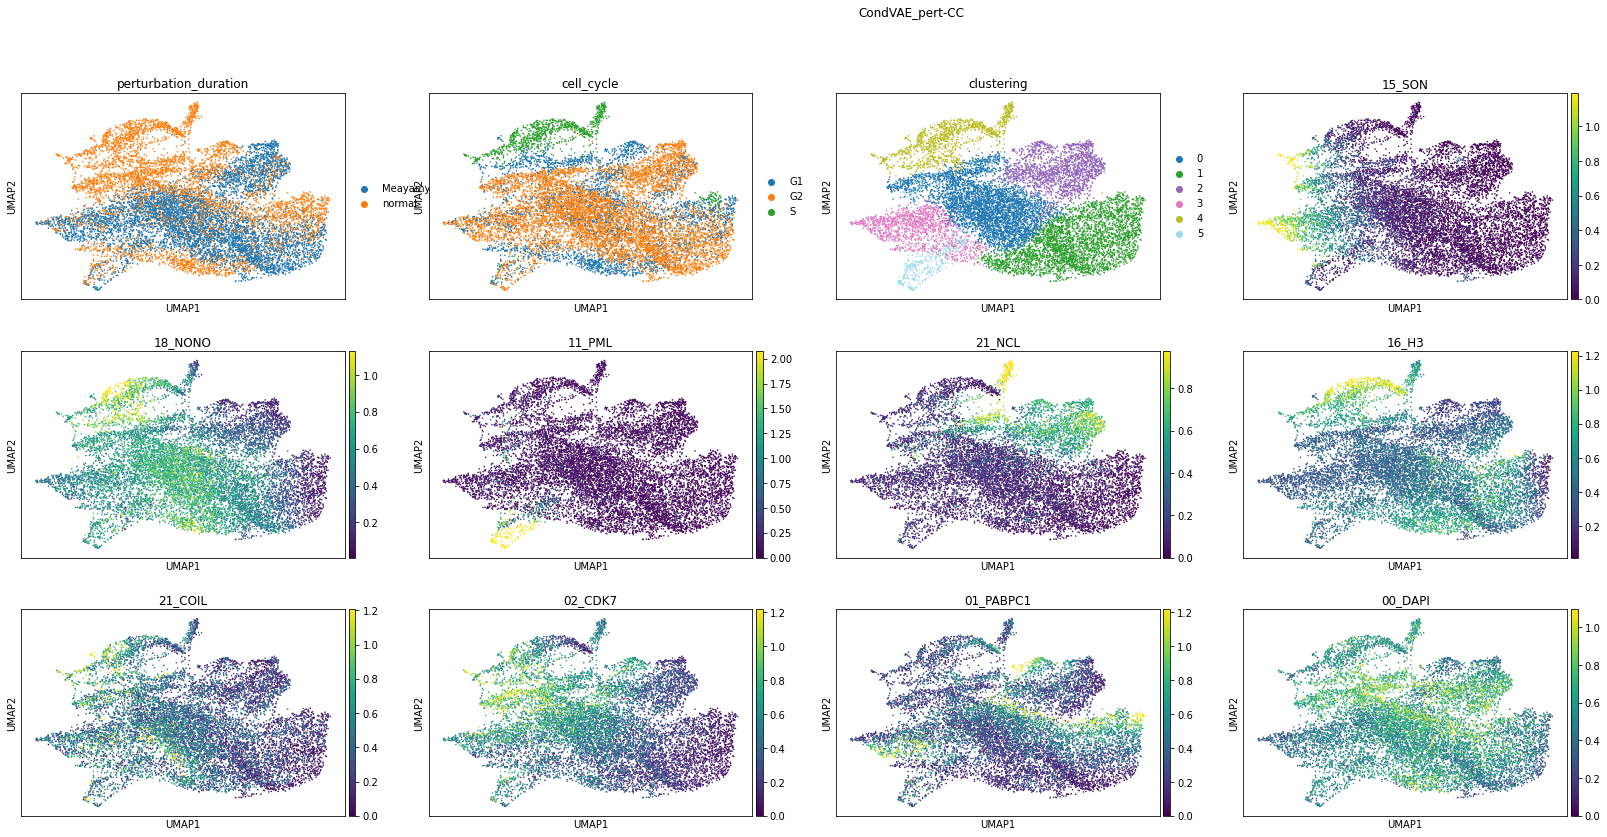

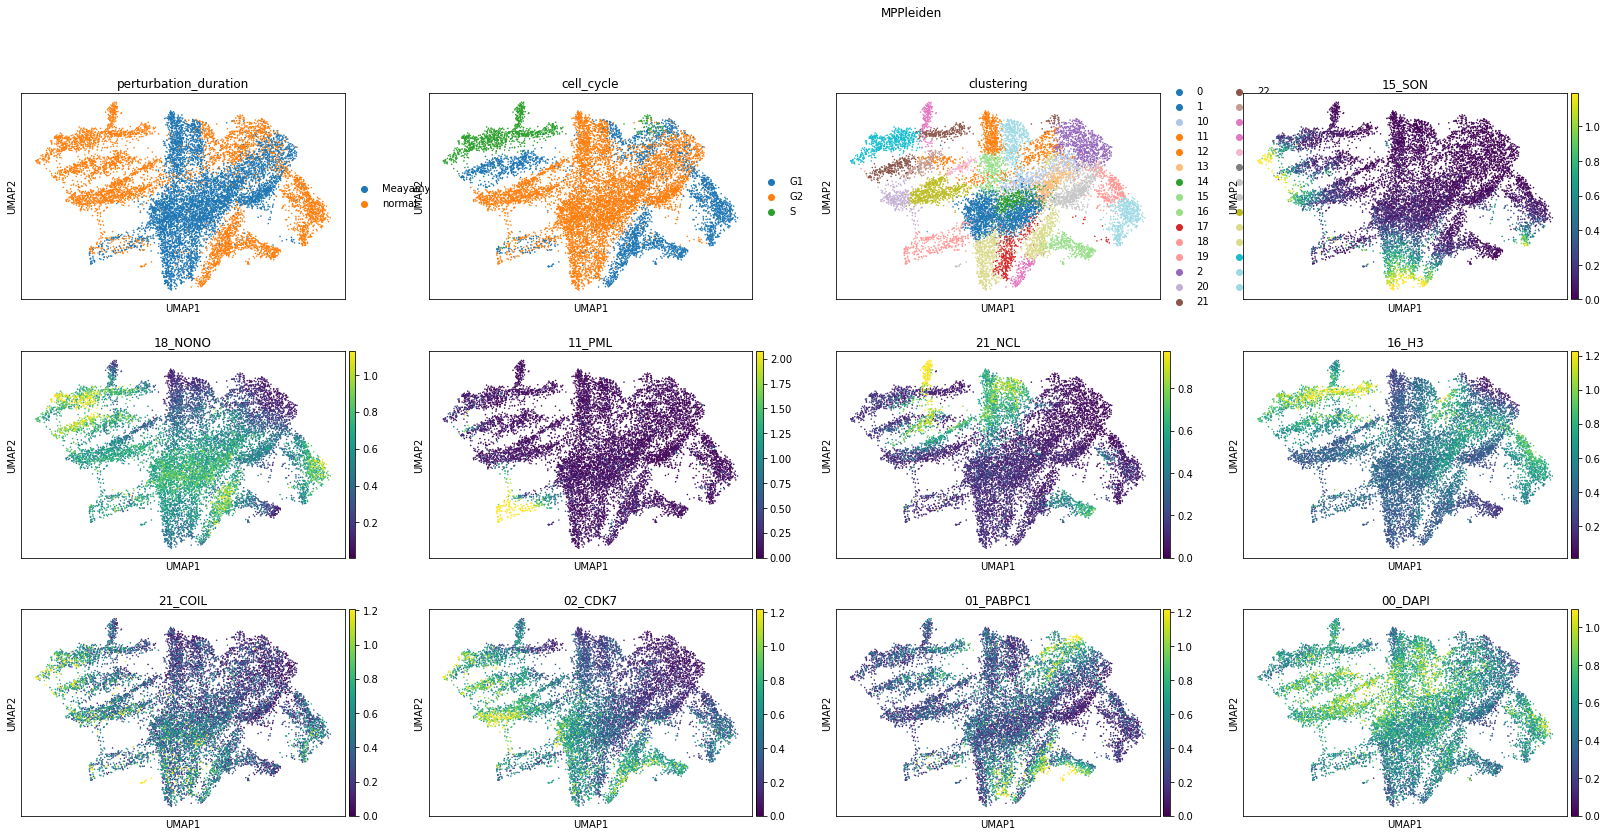

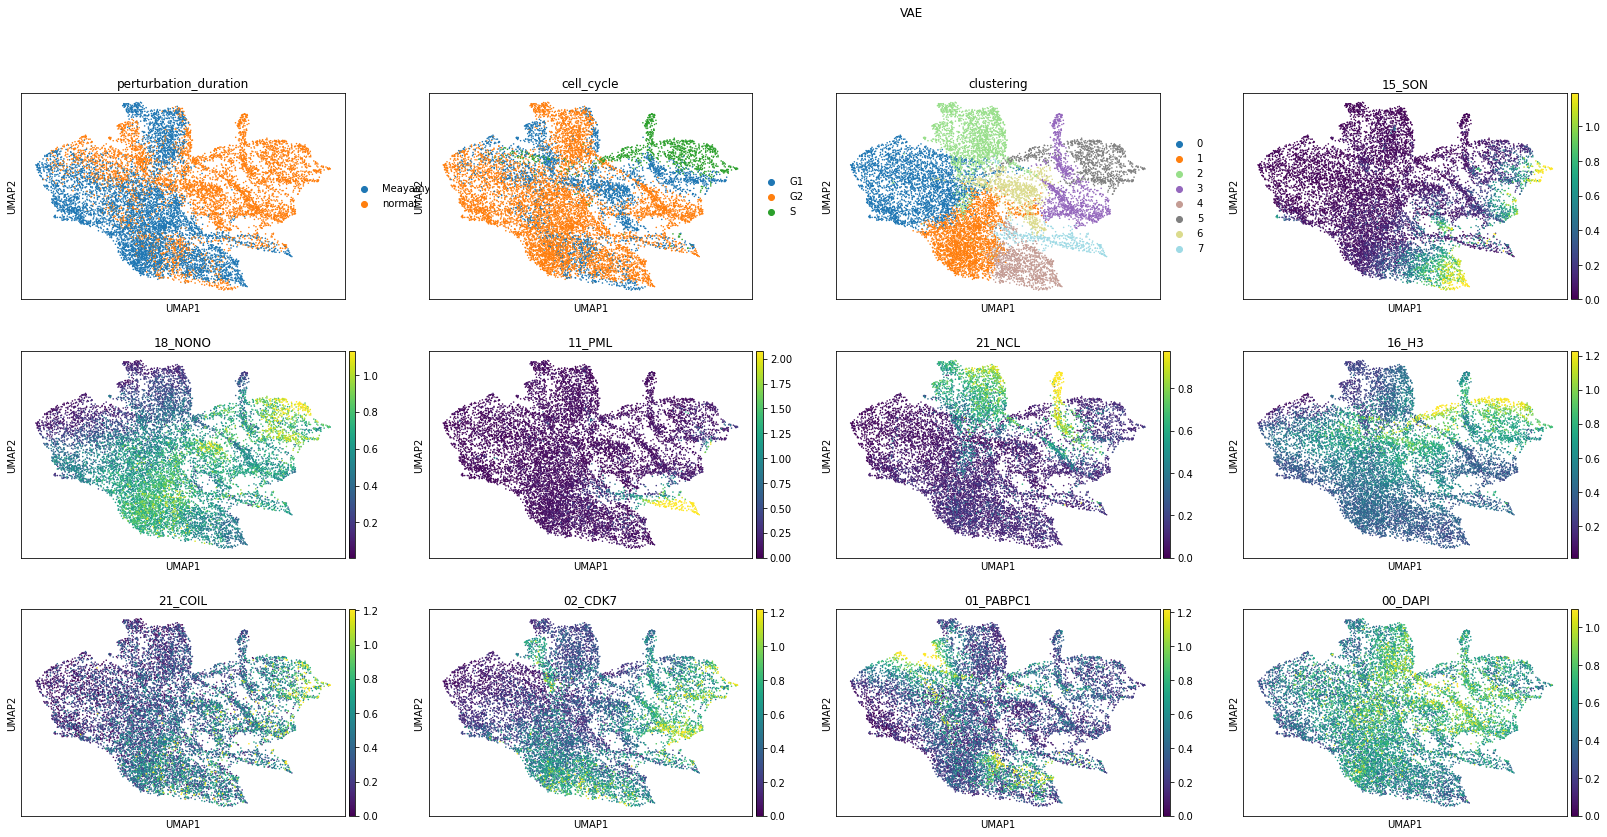

In [ ]:
comp.plot_umap()

To generate CSLs using the learned latent space of the condVAE model, have a look at [the clustering tutorial](cluster.ipynb).